In [1]:
from sippy import *
import numpy as np
import pandas as pd
import plots
from scipy.signal import detrend, butter, filtfilt

## <div align="center">Fractionator example</div>
<img src="frac.jpg">

**Reflux (FIC-2001)**
Increasing reflux (and keeping everything else constant) will decrease the Top Product (FIC-2101) and increase the bottoms product (FIC-2102) by the same amount.

**Mid Product (FIC-2002)**
Increasing the side draw FIC-2002 will affect FIC-2101 and FIC-2102. If we increase the side draw by 1 unit then both top and bottoms product will have to decrease by 1 unit.

**Feed Temperature (TIC-2003)**
Increasing the feed temperature also affects the mass balance in the fractionator and the feed is split in the top and bottoms product.

**Mid Reflux (FIC-2004)**
Increasing the mid reflux (FIC-2004) will also affect both top and bottoms product flow:

In [2]:
#load spteptest data from a TSV file
file = r'..\data\FRAC2.csv'

step_test_data = pd.read_csv(file,header=[0, 1,2,3],index_col=[0], parse_dates=[0])
step_test_data.head()

Time,AI-2020,Quality,AI-2021,Quality,AI-2022,Quality,FIC-2100,Quality,FIC-2101,Quality,...,FIC-2001,Quality,FIC-2002,Quality,FIC-2004,Quality,QI-2106,Quality,TIC-2003,Quality
,AI-2020,Unnamed: 2_level_1,AI-2021,Unnamed: 4_level_1,AI-2022,Unnamed: 6_level_1,FIC-2100,Unnamed: 8_level_1,FIC-2101,Unnamed: 10_level_1,...,FIC-2001,Unnamed: 16_level_1,FIC-2002,Unnamed: 18_level_1,FIC-2004,Unnamed: 20_level_1,QI-2106,Unnamed: 22_level_1,TIC-2003,Unnamed: 24_level_1
,OVERHEAD C5'S,Unnamed: 2_level_2,MIDDLE C7'S,Unnamed: 4_level_2,BOTTOM C3'S,Unnamed: 6_level_2,FEED FURNACE FUEL,Unnamed: 8_level_2,TOP PRODUCT,Unnamed: 10_level_2,...,TOP REFLUX SETPOINT,Unnamed: 16_level_2,MIDDLE PRODUCT DRAW SETPOINT,Unnamed: 18_level_2,MIDDLE REFLUX SETPOINT,Unnamed: 20_level_2,MIDDLE REFLUX DUTY,Unnamed: 22_level_2,FEED TEMPERATURE SETPOINT,Unnamed: 24_level_2
,MOL,Unnamed: 2_level_3,MOL,Unnamed: 4_level_3,MOL,Unnamed: 6_level_3,NRG/H,Unnamed: 8_level_3,MBBL/D,Unnamed: 10_level_3,...,MBBL/D,Unnamed: 16_level_3,MBBL/D,Unnamed: 18_level_3,MBBL/D,Unnamed: 20_level_3,NRG/H,Unnamed: 22_level_3,DEG F,Unnamed: 24_level_3
2015-10-01 08:14:00,2.00000,G,3.00000,G,4.00000,G,8.50000,G,2.10000,G,...,2.5,G,1.5,G,8.0,G,2.00000,G,200.0,G
2015-10-01 08:15:00,2.00360,G,3.00954,G,3.99831,G,8.50735,G,2.09686,G,...,2.5,G,1.5,G,8.0,G,1.99772,G,200.0,G
2015-10-01 08:16:00,2.00870,G,2.99518,G,3.97746,G,8.50977,G,2.09280,G,...,2.5,G,1.5,G,8.0,G,1.99552,G,200.0,G
2015-10-01 08:17:00,2.00385,G,3.01356,G,3.97262,G,8.50838,G,2.08587,G,...,2.5,G,1.5,G,8.0,G,1.99483,G,200.0,G
2015-10-01 08:18:00,1.99852,G,3.02963,G,3.98841,G,8.50365,G,2.08028,G,...,2.5,G,1.5,G,8.0,G,1.99465,G,200.0,G


In [3]:
#slice data for model identification case
start = '2015-10-02 05:14:00'
end = '2015-10-05 09:13:00'
step_test = step_test_data.loc[start:end]

#Drop mutilevel index
step_test.columns = [col[0] for col in step_test.columns]

#Drop quality column, qulity information can be used to drop column but all CSV may not contain quality a saple code is given below.
step_test = step_test.loc[(step_test == 'G').any(1)]
step_test = step_test.drop('Quality' , axis='columns')

#Remove -9999
step_test = step_test.loc[(step_test >- 9999).any(1)]

#get time stamp for ploting
Time = step_test.index

#inspect dataframe
step_test.head()
# step_test.columns
# step_test.shape

,AI-2020,AI-2021,AI-2022,FIC-2100,FIC-2101,FIC-2102,FI-2005,FIC-2001,FIC-2002,FIC-2004,QI-2106,TIC-2003
2015-10-02 05:14:00,1.79025,3.25618,4.31966,8.48585,2.09035,1.36061,5.78924,3.0,1.5,8.5,2.55616,200.0
2015-10-02 05:15:00,1.78843,3.26513,4.30975,8.48206,2.08341,1.36606,5.79211,3.0,1.5,8.5,2.55929,200.0
2015-10-02 05:16:00,1.79303,3.25387,4.30674,8.48012,2.09717,1.35851,5.76505,3.0,1.5,8.5,2.55834,200.0
2015-10-02 05:17:00,1.79985,3.24287,4.28263,8.47538,2.10629,1.36849,5.74577,3.0,1.5,8.5,2.55665,200.0
2015-10-02 05:18:00,1.80037,3.23815,4.27179,8.47844,2.11857,1.38291,5.74937,3.0,1.5,8.5,2.56038,200.0


In [4]:
#select Inputs and Outputs for the model identification case
#['AI-2020','AI-2021', 'AI-2022', 'FIC-2100', 'FIC-2101', 'FIC-2102', 'FI-2005', 'FIC-2001','FIC-2002', 'FIC-2004','QI-2106', 'TIC-2003']
inputs = ['FIC-2001','FIC-2002', 'TIC-2003', 'FIC-2004','FI-2005']
outputs = ['FIC-2101','FIC-2102']

In [5]:
#Convert dataframe to numpy arry.
u = step_test[inputs].to_numpy().T
y = step_test[outputs].to_numpy().T
print('Output shape:', y.shape)
print('Input shape:',u.shape)

Output shape: (2, 4560)
Input shape: (5, 4560)


In [6]:
#specify model identification parameters, reffer the documentation for detais.
model = 'frac2.npz' #model file name
method='CVA'
IC = 'AIC' # None, AIC, AICc, BIC
TH = 30 # The length of time horizon used for regression
fix_ordr = 25 # Used if and only if IC = 'None'
max_order = 25 # Used if IC = AIC, AICc or BIC
req_D = False
force_A_stable = False

In [7]:
# Detrending anf filtering signals
tss = 180 #Time to steady state
u_detend = detrend(u, type='linear')
y_detend = detrend(y, type='linear')

b, a = butter(10, 2/3/tss, 'highpass', analog=True) #filter any frequency  slower than 3*tss
u_filt = filtfilt(b, a, u_detend, method="gust")
y_filt = filtfilt(b, a, y_detend, method="gust")

In [8]:
sys_id = system_identification(
    y_filt, 
    u_filt, 
    method,
    SS_fixed_order=fix_ordr,
    SS_max_order=max_order,
    IC=IC,
    SS_f=TH,
    SS_p=TH,
    SS_D_required=req_D,
    SS_A_stability=force_A_stable
    )

#print model order
# print('Model order:', sys_id.n)

#save model parameters A, B, C,D and X0 as npz file
np.savez(model, A=sys_id.A, B=sys_id.B, C=sys_id.C, D=sys_id.D, K=sys_id.K, X0=sys_id.x0)

The suggested order is: n= 5


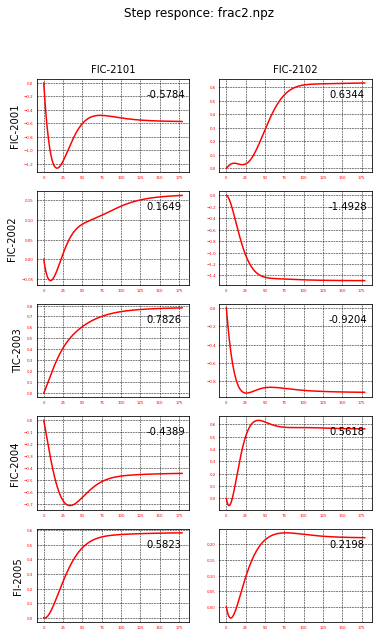

In [9]:
plots.plot_model(model, inputs, outputs, tss=tss)

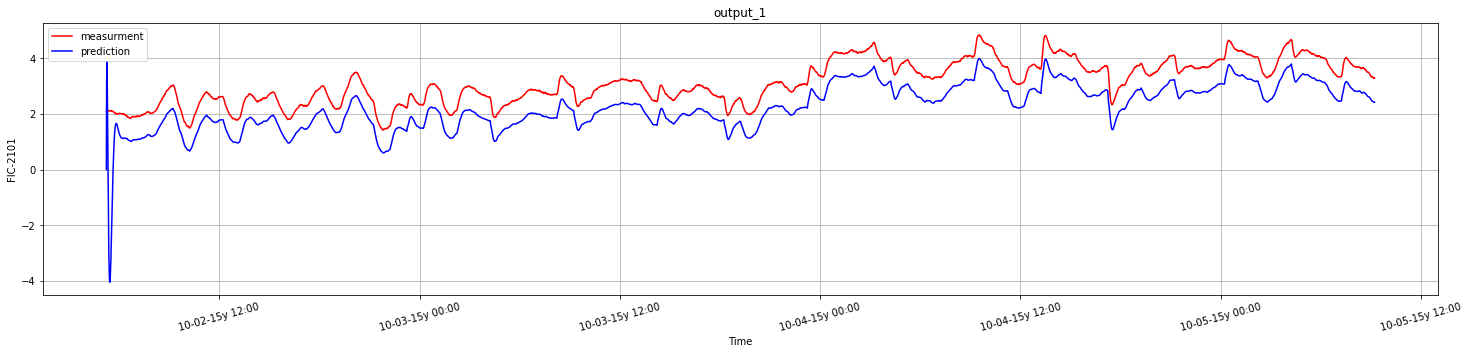

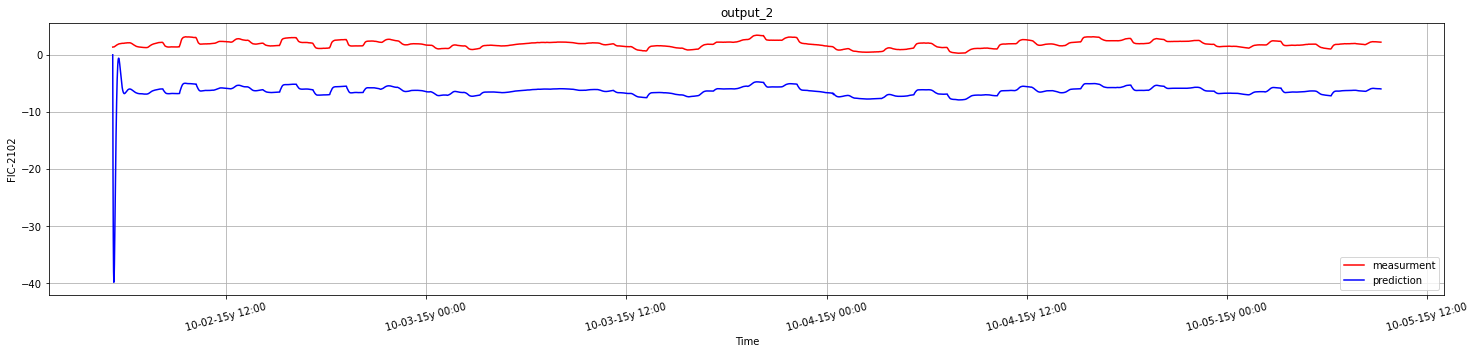

In [10]:
start_time = start
end_time = end
plots.plot_comparison(step_test_data, model, inputs, outputs, start_time, end_time, plt_input= False,scale_plt=False)